In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import CatalogPrior
from smc.images import ImageAttributes

import torch
# torch.cuda.is_available()
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

In [2]:
num_images = 1
img_dim = 15 # Needs to be square for now
img_width = img_dim
img_height = img_dim
max_objects = 10
psf_stdev = 3.25
background_intensity = 19200

image_attributes = ImageAttributes(img_width = img_width,
                                   img_height = img_height,
                                   max_objects = max_objects,
                                   psf_stdev = psf_stdev,
                                   background_intensity = background_intensity)

true_counts, true_fluxes, true_locs, true_total_intensities, images = image_attributes.generate(num_images)

In [3]:
for i in range(num_images):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal flux\n", true_fluxes[i].sum().item(),
          "\nloc\n", true_locs[i].cpu().numpy(), "\n\n")

image 1 
count
 4 
total flux
 286367.125 
loc
 [[ 0.         0.       ]
 [11.290261   1.5768375]
 [12.539728  10.062885 ]
 [ 7.013107  14.852447 ]
 [ 5.238089   4.2609034]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]] 




True count: 4
True total flux: 286367.125

Starting the sampler...
iteration 5, temperature = 0.0008661208557896316, posterior mean count = 4.13873815536499
iteration 10, temperature = 0.0032788151875138283, posterior mean count = 4.408565521240234
iteration 15, temperature = 0.007527665235102177, posterior mean count = 4.491881370544434
iteration 20, temperature = 0.01671612076461315, posterior mean count = 4.576935768127441
iteration 25, temperature = 0.0433666966855526, posterior mean count = 4.611618995666504
iteration 30, temperature = 0.10700725018978119, posterior mean count = 4.581571578979492
iteration 35, temperature = 0.3198871612548828, posterior mean count = 4.4862895011901855
iteration 40, temperature = 0.8841911554336548, posterior mean count = 4.3827362060546875
iteration 45, temperature = 0.9963809847831726, posterior mean count = 4.37546443939209
iteration 50, temperature = 0.9998868703842163, posterior mean count = 4.375585556030273
Done!

summary
number of SMC itera

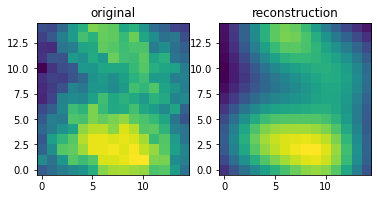

In [4]:
max_objects_smc = max_objects + 2
prior = CatalogPrior(max_objects_smc, img_width, img_height, background_intensity/3.)
smc = SMCsampler(images[0], image_attributes, prior, num_blocks = max_objects_smc+1, catalogs_per_block = 500, max_smc_iters = 1000)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)
smc.summarize()